# Optimizers

In this part we are going to deal with how to do stochastic gradients. There are different type of gradient methods to address the problems arising during optimization. We will cover the different optimizers in the order of their appearance. During that we will uncover the problems they solve and approach with which they solve it. 

Generally, we have a loss function and we want to find its minimum point. Each of the loss functions can be derived as a sum of sample loss functions:

\begin{equation}
L_\Theta\left(y_t, y_p\right) = \frac{1}{n}\sum^n_i { l_\Theta\left(y^{(i)}_t, y^{(i)}_p \right) }.
\end{equation}

The goal is to minimize the $L_\Theta$ function. This requires to calculate the $l_\Theta$ for all the samples which can take a lot of time. To avoid that, the common approach is to draw a batch of samples from the training data and calculate the loss (and what is more important the gradient) according to that. The larger the batch, the closer it is to the gradient calculated on the whole dataset. When the batch size becomes smaller the speed of calculating the gradient becomes faster but also noisier. Optimizers are different in the way how they update the parameters according to the gradient. To make it simple what one can do with the optimization process is to accumulate the gradients or change the learning rate adaptively. The research community have found clever ways to do that and now we have different optimizer strategies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multilayer_nn import activations
from multilayer_nn import optimizers

In [2]:
def plot_learning_path(view, loss, path):
    # contruct the x, y plane
    x_min, x_max, y_min, y_max = view
    delta_x = (x_max - x_min) / 100
    delta_y = (y_max - y_min) / 100
    x, y = [], []
    for i in range(101):
        x.append(x_min + delta_x * i)
        y.append(y_min + delta_y * i)
    X, Y = np.meshgrid(x, y)
    
    # calculate the error surface
    Z = loss(X, Y)
    
    # plot the surface and the path in the parameter space
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)
    ax.plot(path[0], path[1], 'ro')
    ax.set_title('Learning path with loss contour curves')
    ax.set_xlabel("Theta1")
    ax.set_ylabel("Theta2")

In [3]:
# input data
x = np.array([[1.2, 2.0], [1.6, 1.1], [-0.67, -0.2], [-1.14, -1.63], [4.3, 5.5], [3.2, 3.8]])

![optim](images/optim.png)

The image above shows the applied model during learning. We have only two adjustable parameters to make the illustration of the parameter space easy. 

\begin{equation}
y = \sigma \left( x_1 \cdot \Theta_1 + x_2 \cdot \Theta_2 \right),
\end{equation}

where $\sigma$ means the sigmoid function. Let's suppose the solution is $\Theta_1 = 0.2$, $\Theta_2 = 0.6$. The initial value of the parameters will be: $\Theta_1 = 5.2$ and $\Theta_2 = 2.7$. For the model we assume MSE loss.

In [4]:
# The optimal parameters. The expected solution.
theta_0 = np.array([0.3, 0.4])

In [5]:
sigmoid = activations.Sigmoid().activate
def model(theta, x):
    return sigmoid(np.matmul(x, theta))

In [6]:
def grad(theta, x):
    y = model(theta, x)
    y_0 = model(theta_0, x)
    return np.matmul((y - y_0) * y * (1 - y), x) / x.shape[0]

In [7]:
# A function for running an optimization
def optimize(x, op, iter_num, init):
    # x - input in the training set
    # op - optimizer (like Adam)
    # iter_num - number of optimization steps
    path = [[], []]
    theta = [np.array([init[0], init[1]])]
    for ep in range(iter_num):
        path[0].append(theta[0][0])
        path[1].append(theta[0][1])
        np.random.shuffle(x)
        x_batch = x[0:3]
        g = grad(theta[0], x_batch)
        op.optimizer_step(theta, [g])
    view = (min(path[0]), max(path[0]), min(path[1]), max(path[1]))
    return path, view

In [8]:
def loss_generator(x):
    def loss(theta_1, theta_2):
        th = np.array([theta_1, theta_2])
        y = sigmoid(np.tensordot(x, th, axes=(1, 0)).transpose((1, 2, 0)))
        y0 = model(theta_0, x)
        z= np.sum((y - y0) * (y - y0), axis=2)  # MSE loss
        return z
    return loss

loss = loss_generator(x)

## SGD 

SGD means Stochastic Gradient Descent. Originally, SGD means that the batch size is one but in practice it has such a high variance that it is not a widespreaded approach, instead we use the Minibatch Gradient Descent, which has the principles we discussed in the previous paragraph. Nowadays, the term SGD means the Minibatch Gradient Descent. But furthermore we think of vanilla-SGD under the term SGD. Vanilla in this context means that the gradients are directly applied on the parameters, there is nothing to do with the learning rate and the gradients.

The formula:

\begin{equation}
\Theta \leftarrow \Theta - \alpha \cdot \frac{\partial L}{\partial \Theta} 
\end{equation}

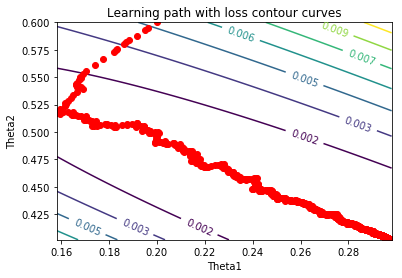

In [9]:
# an example for the convergence behavior
op = optimizers.SGD(1)
path, view = optimize(x, op, 1000, (0.2, 0.6))
plot_learning_path(view, loss, path)

It can be see the SGD was able to find the solution but it uses high learning rate and requires 1000 steps. The path is quite noisy but steadily goes to the solution point. 

## Momentum

The method of Momentum:

\begin{align}
v_0 &=& 0 \\
v_{t} &=& \gamma \cdot v_{t-1} + \alpha \cdot g \\
\Theta_{t+1} &=& \Theta_t - v_t
\end{align}

where $v$ is the momentum which is basically an aggregation of the gradients met so far, $g$ is the gradient vector. 

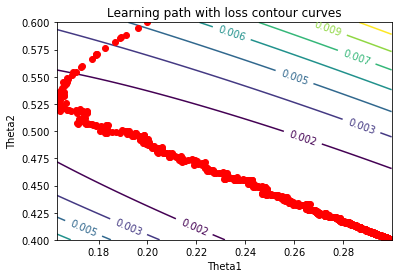

In [10]:
op = optimizers.Momentum(0.95, 1)
path, view = optimize(x, op, 1500, (0.2, 0.6))
plot_learning_path(view, loss, path)

## Adam

The method:

\begin{align}
m_0 &=& 0 \\
v_0 &=& 0 \\
m_t &=& \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g \\
v_t &=& \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g \cdot g \\
\hat{m} &=& \frac{m_t}{1 - \beta^t_1} \\
\hat{v} &=& \frac{v_t}{1 - \beta^t_2} \\
\Theta_{t+1} &=& \Theta_t - \alpha \cdot \frac{1}{\sqrt{\hat{v}}} \cdot \hat{m}
\end{align}

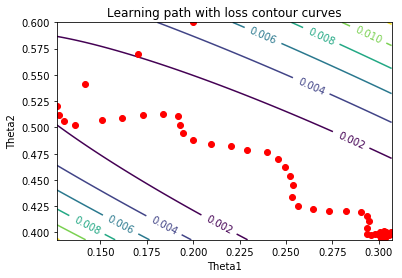

In [11]:
op = optimizers.Adam(0.8, 0.9, 0.03)
path, view = optimize(x, op, 50, (0.2, 0.6))
plot_learning_path(view, loss, path)

[Adam](https://arxiv.org/pdf/1412.6980.pdf)

## Adadelta

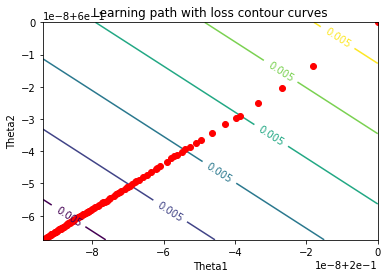

In [12]:
op = optimizers.Adadelta(0.001)
path, view = optimize(x, op, 100, (0.2, 0.6))
plot_learning_path(view, loss, path)

[Adadelta](https://arxiv.org/pdf/1212.5701.pdf)

## RMSProp

The method:

\begin{align}
G_0 &=& 0 \\
G_t &=& \gamma \cdot G_{t-1} + (1 - \gamma) \cdot g \cdot g \\
\Theta_t &=& \Theta_{t-1} - \frac{\alpha}{\sqrt{G_t}} \cdot g
\end{align}

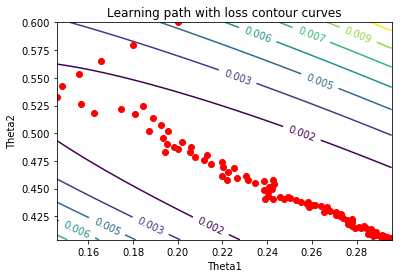

In [13]:
op = optimizers.RMSProp(0.02, 0.02)
path, view = optimize(x, op, 100, (0.2, 0.6))
plot_learning_path(view, loss, path)

[Reference](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

## Adagrad

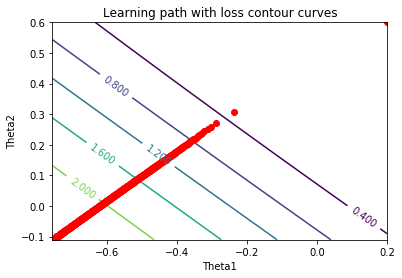

In [14]:
op = optimizers.Adagrad(0.002)
path, view = optimize(x, op, 600, (0.2, 0.6))
plot_learning_path(view, loss, path)

### Further references

[Overview of optimizers by Ruder](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) <br/>